In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss, brier_score_loss

In [11]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, weights=[0.7, 0.3],
                           random_state=42)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Newtwon-cg
##### Works best for:

- Small to medium datasets (thousands of samples, not millions). <br>
- Dense data (not too sparse). <br>
- When you want high accuracy quickly and don’t mind heavier computation per step. <br>

##### Downside: 
- Memory- and compute-heavy → not good for huge datasets. <br>

In [13]:
# Method-1 From scratch the behind the scences for LogisticRegrssion
class LogisticRegressionNewtonCG(BaseEstimator, ClassifierMixin):
    def __init__(self, tol=1e-6, max_iter=5):
        self.tol = tol
        self.max_iter = max_iter
        self.coef_ = None
        self.classes_ = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Save class labels
        self.classes_ = np.unique(y)

        # Force binary for now
        if len(self.classes_) != 2:
            raise ValueError("This implementation only supports binary classification.")

        # Convert y to {0,1}
        y = (y == self.classes_[1]).astype(int)

        n_samples, n_features = X.shape
        X = np.hstack([np.ones((n_samples, 1)), X])  # add intercept
        self.coef_ = np.zeros(n_features + 1)

        for _ in range(self.max_iter):
            z = X.dot(self.coef_)
            p = self.sigmoid(z)

            grad = X.T.dot(p - y)
            D = np.diag(p * (1 - p))
            H = X.T.dot(D).dot(X)

            delta = np.linalg.solve(H, grad)
            self.coef_ -= delta

            if np.linalg.norm(delta) < self.tol:
                break

        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        X = np.hstack([np.ones((n_samples, 1)), X])
        probs = self.sigmoid(X.dot(self.coef_))
        return np.column_stack([1 - probs, probs])

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)



newton_model = LogisticRegressionNewtonCG()
newton_model.fit(X_train, y_train)

# Method-2

# newton_model = LogisticRegression(solver='newton-cg', max_iter=10,C=10)
# newton_model.fit(X_train, y_train)

LogisticRegressionNewtonCG()

## SAGA (Stochastic Average Gradient Accelerated)

- First-order, SGD-like method.

- Designed for:
    - Very large datasets (millions of samples).
    - Sparse features (like text, bag-of-words, TF-IDF).
    - Slower per iteration but much more scalable.
    - Supports L1 regularization (feature selection), which Newton-CG does not.

In [14]:
sgd_model = LogisticRegression(solver='saga', max_iter=100)
sgd_model.fit(X_train, y_train)

LogisticRegression(solver='saga')

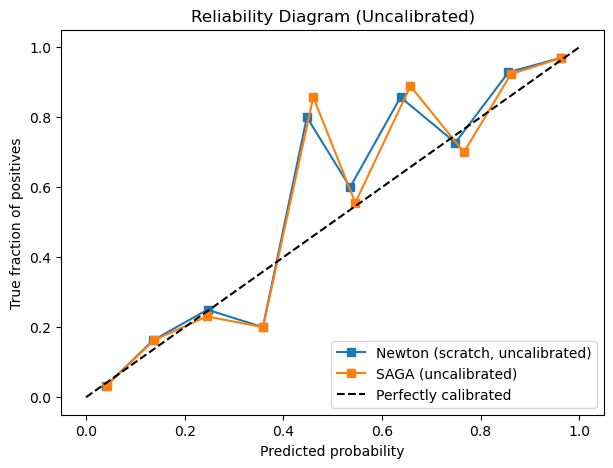

In [15]:
def plot_calibration_curve(model, name, X_test, y_test):
    prob_pos = model.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, "s-", label=name)

plt.figure(figsize=(7, 5))
plot_calibration_curve(newton_model, "Newton (scratch, uncalibrated)", X_test, y_test)
plot_calibration_curve(sgd_model, "SAGA (uncalibrated)", X_test, y_test)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Reliability Diagram (Uncalibrated)")
plt.legend()
plt.show()

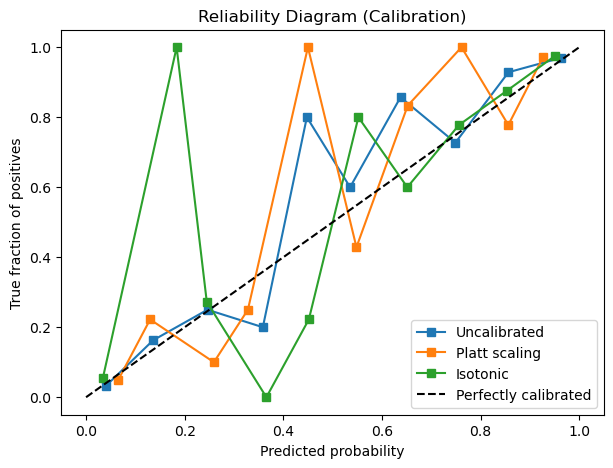

In [16]:
# Train base Newton-CG scratch model
newton_model = LogisticRegressionNewtonCG(max_iter=100)
newton_model.fit(X_train, y_train)

# Apply calibration
platt = CalibratedClassifierCV(newton_model, method='sigmoid', cv=5)
platt.fit(X_train, y_train)

isotonic = CalibratedClassifierCV(newton_model, method='isotonic', cv=5)
isotonic.fit(X_train, y_train)

# Plot reliability diagram
plt.figure(figsize=(7,5))
plot_calibration_curve(newton_model, "Uncalibrated", X_test, y_test)
plot_calibration_curve(platt, "Platt scaling", X_test, y_test)
plot_calibration_curve(isotonic, "Isotonic", X_test, y_test)
plt.plot([0,1],[0,1],"k--",label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Reliability Diagram (Calibration)")
plt.legend()
plt.show()


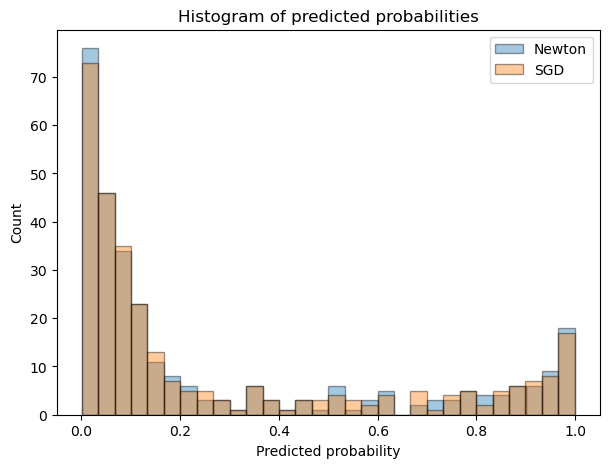

In [17]:
plt.figure(figsize=(7,5))
for clf, name in [(newton_model, "Newton"), (sgd_model, "SGD")]:
    prob_pos = clf.predict_proba(X_test)[:,1]
    plt.hist(prob_pos, bins=30, alpha=0.4, label=name, edgecolor="black")

plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Histogram of predicted probabilities")
plt.legend()
plt.show()


In [18]:
for clf, name in [(newton_model, "Newton"), (sgd_model, "SGD"), (platt, "Platt"), (isotonic, "Isotonic")]:
    prob_pos = clf.predict_proba(X_test)[:,1]
    print(f"{name:10s} | Log-loss: {log_loss(y_test, prob_pos):.3f} | Brier: {brier_score_loss(y_test, prob_pos):.3f}")

Newton     | Log-loss: 0.275 | Brier: 0.080
SGD        | Log-loss: 0.276 | Brier: 0.081
Platt      | Log-loss: 0.284 | Brier: 0.081
Isotonic   | Log-loss: 0.283 | Brier: 0.081


## Key Takeaways

- Newton-CG is faster locally but heavy for large data.  
- SAGA is scalable and handles sparse data.  
- Calibration ensures probability estimates are meaningful.  
- Use reliability diagrams + Brier score to check calibration.  
- Apply **Platt scaling or isotonic regression** to fix calibration issues.  